## Hyperparam Tuning

Now that we know which models are performing better, it's time to perform cross validation and tune hyperparameters.
- Do a google search for hyperparameter ranges for each type of model.

GridSearch/RandomSearch are a great methods for checking off both of these tasks.

There is a fairly significant issue with this approach for this particular problem (described below). But in the interest of creating a basic functional pipeline, you can just use the default Sklearn methods for now.

## Preventing Data Leakage in Tuning - STRETCH

> **This step doesn't need to be part of your Minimum Viable Product (MVP), but its highly recommended you complete it, if you have time!**

BUT we have a problem - if we calculated a numerical value to encode city (such as the mean of sale prices in that city) on the training data, we can't cross validate 
- The rows in each validation fold were part of the original calculation of the mean for that city - that means we're leaking information!
- While sklearn's built in functions are extremely useful, sometimes it is necessary to do things ourselves

You need to create two functions to replicate what Gridsearch does under the hood. This is a challenging, real world data problem! To help you out, we've created some psuedocode and docstrings to get you started. 

**`custom_cross_validation()`**
- Should take the training data, and divide it into multiple train/validation splits. 
- Look into `sklearn.model_selection.KFold` to accomplish this - the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) shows how to split a dataframe and loop through the indexes of your split data. 
- Within your function, you should compute the city means on the training folds just like you did in Notebook 1 - you may have to re-join the city column to do this - and then join these values to the validation fold

This psuedocode may help you fill in the function:

```python
kfold = KFold() # fit sklearn k folds on X_train
train_folds = []
val_folds = []
for training_index, val_index in kfold.split(X_train):
    train_fold, val_fold = #.iloc loop variables on X_train

    # recompute training city means like you did in notebook 1 
    # merge to validation fold
        
    train_folds.append(train_fold)
    val_folds.append(val_fold)

    return train_folds, val_folds
```


**`hyperparameter_search()`**
- Should take the validation and training splits from your previous function, along with your dictionary of hyperparameter values
- For each set of hyperparameter values, fit your chosen model on each set of training folds, and take the average of your chosen scoring metric. [itertools.product()](https://docs.python.org/3/library/itertools.html) will be helpful for looping through all combinations of hyperparameter values
- Your function should output the hyperparameter values corresponding the highest average score across all folds. Alternatively, it could also output a model object fit on the full training dataset with these parameters.


This psuedocode may help you fill in the function:

```python
hyperparams = # Generate hyperparam options with itertools
hyperparam-scores = []
for hyperparam-combo in hyperparams:

    scores = []

    for folds in allmyfolds:
        # score fold the fold with the model/ hyperparams
        scores.append(score-fold)
        
    score = scores.mean()
    hyperparam-scores.append(score)
# After loop, find max of hyperparam-scores. Best params are at same index in `hyperparams` loop iteratble
```

Docstrings have been provided below to get you started. Once you're done developing your functions, you should move them to `functions_variables.py` to keep your notebook clean 

Bear in mind that these instructions are just one way to tackle this problem - the inputs and output formats don't need to be exactly as specified here.

In [1]:
import os
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import functions_variables

In [2]:
# # Import data and train/test split 

data = pd.read_csv('../processed_data/feature_selected_data.csv')
X = data.drop(columns='sold_price')
y = data['sold_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

In [3]:
data

,baths,type,sqft,central_air,community_outdoor_space,garage_2_or_more,community_security_features,farm,encoded_city,encoded_state,sold_price
0,2,7,-0.194919,1,1,1,1,0,-0.939592,-0.951020,129900.0
1,2,7,-0.279965,0,0,0,0,0,-0.939592,-0.951020,88500.0
2,2,7,0.359318,1,0,0,0,0,-0.939592,-0.951020,145000.0
3,2,7,-0.238875,1,1,0,0,0,-0.939592,-0.951020,65000.0
4,2,7,0.116601,0,0,0,0,0,-0.939592,-0.951020,169000.0
...,...,...,...,...,...,...,...,...,...,...,...
1436,1,7,-0.447192,1,0,0,0,0,-1.519647,-1.530367,99000.0
1437,1,7,-0.663153,0,0,0,0,0,-1.519647,-1.530367,29700.0
1438,1,7,-0.202563,0,0,0,0,0,-1.519647,-1.530367,162250.0
1439,0,7,-1.607267,0,0,0,0,0,-1.519647,-1.530367,63800.0


In [4]:
# develop your custom functions here
from sklearn.model_selection import KFold

def custom_cross_validation(training_data, target_column, n_splits=5):
    '''Creates n_splits sets of training and validation folds while ensuring 
       encoding features (like city mean prices) are recomputed within each fold.

    Args:
      training_data: Pandas DataFrame containing features and target.
      target_column: The column name of the target variable (e.g., 'sold_price').
      n_splits: Number of cross-validation folds.

    Returns:
      A tuple of lists: (training_folds, validation_folds).
    '''

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    training_folds = []
    validation_folds = []

    for train_idx, val_idx in kfold.split(training_data):
        train_fold = training_data.iloc[train_idx]
        val_fold = training_data.iloc[val_idx]

        # Compute city mean sale price in the training fold
        city_means = train_fold.groupby("encoded_city")[target_column].mean()
        val_fold["city_mean_price"] = val_fold["encoded_city"].map(city_means)

        training_folds.append(train_fold)
        validation_folds.append(val_fold)

    return training_folds, validation_folds


In [5]:
import itertools
from sklearn.metrics import r2_score

def hyperparameter_search(training_folds, validation_folds, param_grid, model_class):
    '''Finds the best hyperparameters by training models on cross-validation folds 
       and evaluating performance.

    Args:
      training_folds: List of training fold DataFrames.
      validation_folds: List of validation fold DataFrames.
      param_grid: Dictionary of possible hyperparameter values.
      model_class: The machine learning model class (e.g., RandomForestRegressor, XGBRegressor).

    Returns:
      The best hyperparameter combination based on validation performance.
    '''
    
    hyperparams = list(itertools.product(*param_grid.values()))
    best_score = -float("inf")
    best_params = None

    for param_combo in hyperparams:
        param_dict = dict(zip(param_grid.keys(), param_combo))
        scores = []

        for train_fold, val_fold in zip(training_folds, validation_folds):
            model = model_class(**param_dict)
            model.fit(train_fold.drop(columns=['sold_price']), train_fold['sold_price'])
            y_pred = model.predict(val_fold.drop(columns=['sold_price']))
            scores.append(r2_score(val_fold['sold_price'], y_pred))

        avg_score = np.mean(scores)

        if avg_score > best_score:
            best_score = avg_score
            best_params = param_dict

    return best_params


## Hyperparam Tuning

In [6]:
# perform tuning and cross validation here 
# using GridsearchCV/ RandomsearchCV (MVP)
# or your custom functions

In [7]:
import xgboost as xgb

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor()


In [8]:
param_grid_xgb = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.03, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}


In [9]:
from sklearn.model_selection import RandomizedSearchCV

random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model, 
    param_distributions=param_grid_xgb, 
    cv=5, 
    scoring='r2', 
    n_jobs=-1, 
    n_iter=10
)

random_search_xgb.fit(X_train, y_train)

print("Best Randomized Hyperparameters:", random_search_xgb.best_params_)
print("Best Randomized Score:", random_search_xgb.best_score_)


Best Randomized Hyperparameters: {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Best Randomized Score: 0.6633751597650404


In [10]:
from sklearn.model_selection import KFold

def custom_cross_validation(training_data, target_column, n_splits=5):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    training_folds = []
    validation_folds = []

    for train_idx, val_idx in kfold.split(training_data):
        train_fold = training_data.iloc[train_idx]
        val_fold = training_data.iloc[val_idx]

        # Compute city mean sale price on training fold
        city_means = train_fold.groupby("encoded_city")[target_column].mean()

        # Apply transformation to BOTH training and validation folds
        train_fold["city_mean_price"] = train_fold["encoded_city"].map(city_means)
        val_fold["city_mean_price"] = val_fold["encoded_city"].map(city_means)

        training_folds.append(train_fold)
        validation_folds.append(val_fold)

    return training_folds, validation_folds



In [11]:
# Use the best hyperparameters found
best_xgb_params = random_search_xgb.best_params_

# Train final XGBoost model
final_xgb_model = xgb.XGBRegressor(**best_xgb_params)
final_xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [12]:
y_pred = final_xgb_model.predict(X_test)

# Compute performance metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Final Model RMSE: {rmse}")
print(f"Final Model MAE: {mae}")
print(f"Final Model R² Score: {r2}")


Final Model RMSE: 179701.84538301142
Final Model MAE: 104737.37670307093
Final Model R² Score: 0.6644074293046207


We want to make sure that we save our models.  In the old days, one just simply pickled (serialized) the model.  Now, however, certain model types have their own save format.  If the model is from sklearn, it can be pickled, if it's xgboost, for example, the newest format to save it in is JSON, but it can also be pickled.  It's a good idea to stay with the most current methods. 
- you may want to create a new `models/` subdirectory in your repo to stay organized

In [13]:
# save your best model here 
current_dir = os.getcwd()
main_dir = os.path.abspath(os.path.join(current_dir, '..'))
models_dir = os.path.join(main_dir, 'models')
os.makedirs(models_dir, exist_ok=True)
xgb_dir = os.path.join(models_dir, 'xgb_best.json')

final_xgb_model.save_model(xgb_dir)

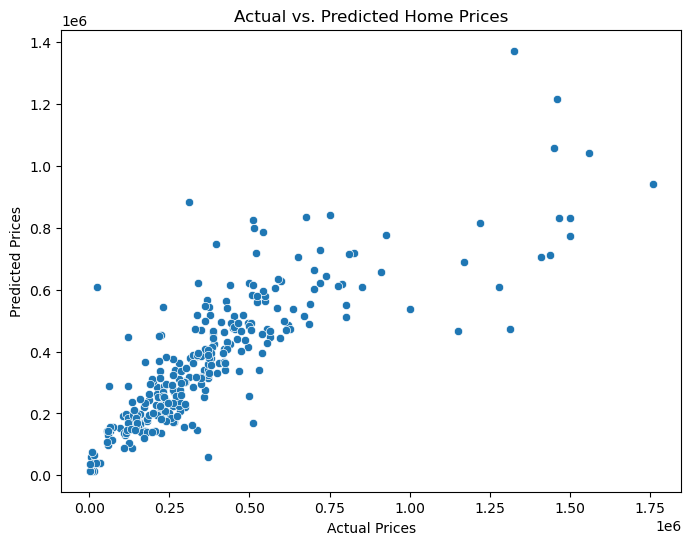

In [14]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs. Predicted Home Prices")
plt.show()

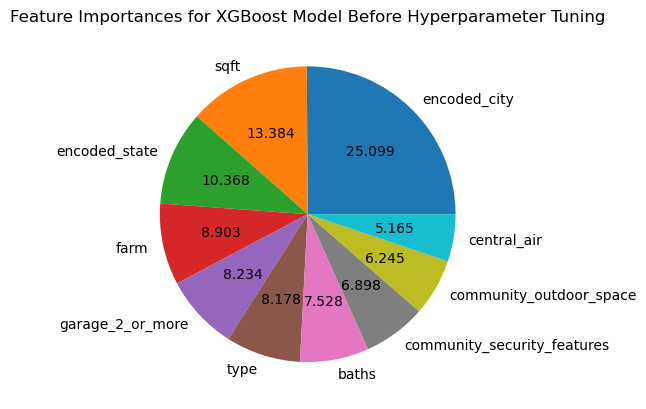

In [15]:
X_trainplt, X_testplt, y_trainplt, y_testplt = train_test_split(X, y, test_size=0.2, random_state=2) # same random state as XGBoost moodel in feature selection 

bad_xgb = xgb.XGBRegressor()
bad_xgb.fit(X_trainplt, y_trainplt)
bad_xgb_pred = bad_xgb.predict(X_testplt)

importance_df = pd.DataFrame({
    "Feature": X_trainplt.columns,
    "Importance": bad_xgb.feature_importances_
}).sort_values(by="Importance", ascending=False)

values = importance_df['Importance']
labels = importance_df['Feature']
plt.pie(values, labels=labels, autopct='%.3f')
plt.title('Feature Importances for XGBoost Model Before Hyperparameter Tuning')

%matplotlib inline

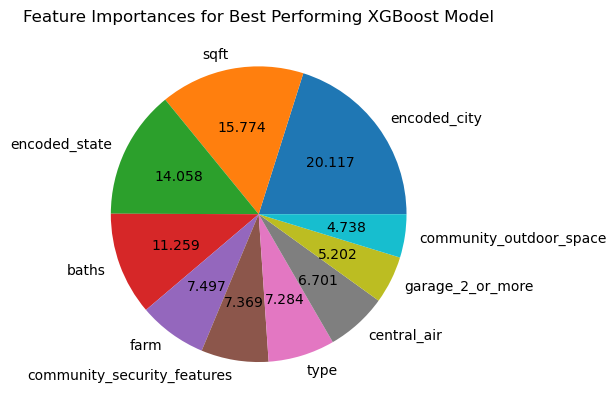

In [16]:
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": final_xgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

importance_df
values = importance_df['Importance']
labels = importance_df['Feature']
plt.pie(values, labels=labels, autopct='%.3f')
plt.title('Feature Importances for Best Performing XGBoost Model')

%matplotlib inline

In [17]:
evaluation_scores = {} 

# Scores before hyperparam tuning 
mseplt = mean_squared_error(y_testplt, bad_xgb_pred)
rmseplt = root_mean_squared_error(y_testplt, bad_xgb_pred)
maeplt = mean_absolute_error(y_testplt, bad_xgb_pred)
r2plt = r2_score(y_testplt, bad_xgb_pred)

n = X_testplt.shape[0]  # Number of observations
p = X_testplt.shape[1]  # Number of predictors
adjusted_r2plt = 1 - ((1 - r2plt) * (n - 1) / (n - p - 1))

# Scores after hyperparam tuning

mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

n = X_test.shape[0]  # Number of observations
p = X_test.shape[1]  # Number of predictors
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))


evaluation_scores['XGBoost Before'] = [mseplt, rmseplt, maeplt, r2plt, adjusted_r2plt]
evaluation_scores['XGBoost After'] = [mse, rmse, mae, r2, adjusted_r2]

evaluation_df = pd.DataFrame.from_dict(
    evaluation_scores, 
    orient="index", 
    columns=["MSE", "RMSE", "MAE", "R² Score", "Adjusted R² Score"] 
)
evaluation_df

,MSE,RMSE,MAE,R² Score,Adjusted R² Score
XGBoost Before,4.793979e+10,218951.567224,124627.201454,0.680772,0.669289
XGBoost After,3.229275e+10,179701.845383,104737.376703,0.664407,0.652336


## Building a Pipeline (Stretch)

> **This step doesn't need to be part of your Minimum Viable Product (MVP), but its highly recommended you complete it if you have time!**

Once you've identified which model works the best, implement a prediction pipeline to make sure that you haven't leaked any data, and that the model could be easily deployed if desired.
- Your pipeline should load the data, process it, load your saved tuned model, and output a set of predictions
- Assume that the new data is in the same JSON format as your original data - you can use your original data to check that the pipeline works correctly
- Beware that a pipeline can only handle functions with fit and transform methods.
- Classes can be used to get around this, but now sklearn has a wrapper for user defined functions.
- You can develop your functions or classes in the notebook here, but once they are working, you should import them from `functions_variables.py` 

In [18]:
current_dir = os.getcwd()
main_dir = os.path.abspath(os.path.join(current_dir, '..'))
data_dir = os.path.join(main_dir, 'data')
csv_dir = os.path.join(main_dir, 'csv_data')
cols_to_scale = ['lot_sqft', 'sqft', 'total_sqft', 'building_ratio', 'encoded_city', 'encoded_state']

from functions_variables import data_cleaning, data_encoding, DataLoader, data_encoding, ColumnScaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer

In [19]:
# Build pipeline here

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline 
import json

clean_transformer = FunctionTransformer(data_cleaning)
encode_transformer = FunctionTransformer(data_encoding)

pipeline = Pipeline([
    ('loading', DataLoader()),
    ('cleaning', clean_transformer),
    ('encoding', encode_transformer),
    ('scaler', ColumnScaler(cols_to_scale))
])

In [20]:
processed = pipeline.fit_transform(data_dir)
X = processed.drop(columns='sold_price')
y = processed['sold_price']
model = xgb.XGBRegressor()
model.load_model(xgb_dir)
model.predict(X)

Skipping malformed file: HI_Honolulu_3.json
Skipping malformed file: HI_Honolulu_4.json
Skipping malformed file: ME_Augusta_0.json
Skipping malformed file: ME_Augusta_1.json
Skipping malformed file: ME_Augusta_2.json
Skipping malformed file: ME_Augusta_3.json
Skipping malformed file: ME_Augusta_4.json
Skipping malformed file: MS_Jackson_0.json
Skipping malformed file: MS_Jackson_1.json
Skipping malformed file: MS_Jackson_2.json
Skipping malformed file: MS_Jackson_3.json
Skipping malformed file: MS_Jackson_4.json
Skipping malformed file: ND_Bismarck_2.json
Skipping malformed file: ND_Bismarck_3.json
Skipping malformed file: ND_Bismarck_4.json
Skipping malformed file: NH_Concord_3.json
Skipping malformed file: NH_Concord_4.json
Skipping malformed file: SD_Pierre_0.json
Skipping malformed file: SD_Pierre_1.json
Skipping malformed file: SD_Pierre_2.json
Skipping malformed file: SD_Pierre_3.json
Skipping malformed file: SD_Pierre_4.json
Skipping malformed file: VT_Montpelier_0.json
Skipping

C:\Users\sherr\LHL classwork\LHL-midterm\notebooks\functions_variables.py:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<IntegerArray>
[1963, <NA>, <NA>, <NA>, <NA>, 1969, 1920, 2002, 1998, 1945,
 ...
 <NA>, <NA>, <NA>, 1925, <NA>, 1910, <NA>, <NA>, <NA>, 1950]
Length: 1795, dtype: Int64' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:, 'year_built'] = df['year_built'].astype('Int64')
C:\Users\sherr\LHL classwork\LHL-midterm\notebooks\functions_variables.py:131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<IntegerArray>
[   1, <NA>, <NA>, <NA>, <NA>, <NA>,    2, <NA>,    2,    1,
 ...
 <NA>, <NA>, <NA>, <NA>,    2,    1, <NA>, <NA>, <NA>, <NA>]
Length: 1795, dtype: Int64' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:, 'garage'] = df[

ValueError: feature_names mismatch: ['baths', 'type', 'sqft', 'central_air', 'community_outdoor_space', 'garage_2_or_more', 'community_security_features', 'farm', 'encoded_city', 'encoded_state'] ['year_built', 'garage', 'stories', 'beds', 'baths', 'type', 'lot_sqft', 'sqft', 'total_sqft', 'building_ratio', 'garage_1_or_more', 'central_air', 'community_outdoor_space', 'dishwasher', 'basement', 'fireplace', 'forced_air', 'single_story', 'two_or_more_stories', 'garage_2_or_more', 'hardwood_floors', 'laundry_room', 'washer_dryer', 'shopping', 'recreation_facilities', 'dining_room', 'community_security_features', 'view', 'central_heat', 'family_room', 'city_view', 'fenced_yard', 'big_lot', 'floor_plan', 'new_roof', 'rental_property', 'updated_kitchen', 'community_swimming_pool', 'farm', 'ensuite', 'corner_lot', 'ranch', 'big_yard', 'modern_kitchen', 'energy_efficient', 'open_floor_plan', 'encoded_city', 'encoded_state']
training data did not have the following fields: community_swimming_pool, view, stories, building_ratio, fenced_yard, family_room, floor_plan, city_view, shopping, modern_kitchen, lot_sqft, basement, central_heat, big_yard, big_lot, two_or_more_stories, laundry_room, garage, beds, washer_dryer, hardwood_floors, energy_efficient, single_story, new_roof, garage_1_or_more, open_floor_plan, ensuite, recreation_facilities, corner_lot, ranch, fireplace, dishwasher, updated_kitchen, forced_air, year_built, rental_property, total_sqft, dining_room


Pipelines come from sklearn.  When a pipeline is pickled, all of the information in the pipeline is stored with it.  For example, if we were deploying a model, and we had fit a scaler on the training data, we would want the same, already fitted scaling object to transform the new data with.  This is all stored when the pipeline is pickled.
- save your final pipeline in your `models/` folder

In [ ]:
# save your pipeline here